# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/tstabrawa/ai-science-training-series/blob/my-edits/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [2]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [3]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 21.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 606kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 5.63MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.38MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [5]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

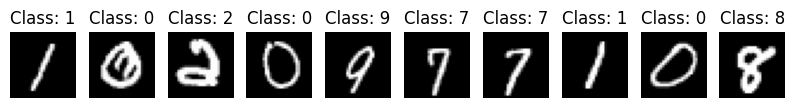

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/tstabrawa/ai-science-training-series/blob/my-edits/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [7]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [8]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [9]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [10]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [11]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [15]:
%%time

epochs = 10
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5038251558939616, accuracy: 87.42083333333333
Epoch 0: val. loss: 0.49698049210487527, val. accuracy: 87.56666666666668
Epoch 1: training loss: 0.4227880341609319, accuracy: 88.8625
Epoch 1: val. loss: 0.4142823273197134, val. accuracy: 88.875
Epoch 2: training loss: 0.38846705758571626, accuracy: 89.60208333333334
Epoch 2: val. loss: 0.37933422498246455, val. accuracy: 89.50833333333334
Epoch 3: training loss: 0.36828152362505595, accuracy: 90.04375
Epoch 3: val. loss: 0.3589234025554454, val. accuracy: 89.93333333333334
Epoch 4: training loss: 0.3545516092777252, accuracy: 90.39583333333333
Epoch 4: val. loss: 0.34516356853728597, val. accuracy: 90.275
Epoch 5: training loss: 0.34440749017397565, accuracy: 90.60000000000001
Epoch 5: val. loss: 0.3350964624513971, val. accuracy: 90.5
Epoch 6: training loss: 0.3365012536843618, accuracy: 90.76875
Epoch 6: val. loss: 0.3273299788223936, val. accuracy: 90.64999999999999
Epoch 7: training loss: 0.3301044676303863

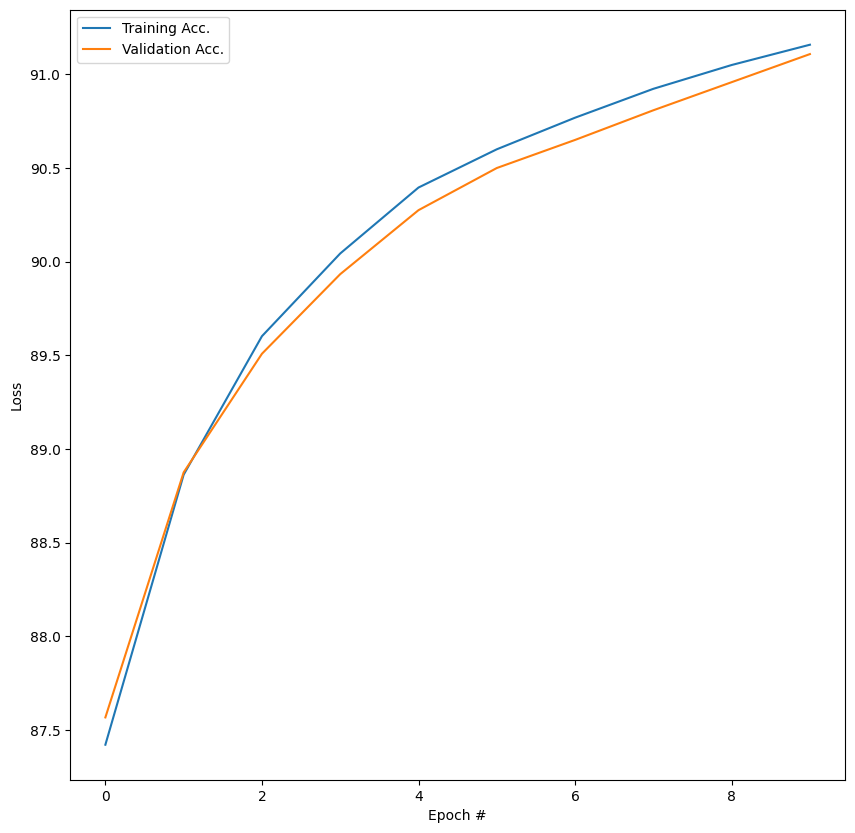

In [16]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

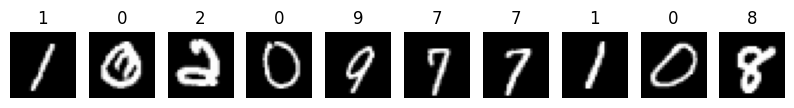

In [17]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [18]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [19]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3030, test accuracy: 91.54%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [20]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


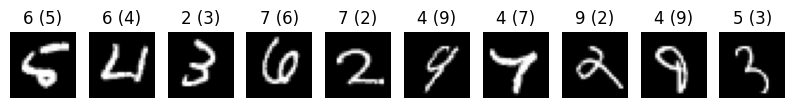

In [21]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/tstabrawa/ai-science-training-series/blob/my-edits/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/tstabrawa/ai-science-training-series/blob/my-edits/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/tstabrawa/ai-science-training-series/blob/my-edits/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/tstabrawa/ai-science-training-series/blob/my-edits/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/tstabrawa/ai-science-training-series/blob/my-edits/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [43]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [25]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [26]:
%%time

epochs = 10
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.6277527651786804, accuracy: 81.575
Epoch 0: val. loss: 0.6175182287363296, val. accuracy: 81.65
Epoch 1: training loss: 0.37840578536192576, accuracy: 89.4
Epoch 1: val. loss: 0.36927488160894273, val. accuracy: 89.28333333333333
Epoch 2: training loss: 0.3065333442687988, accuracy: 91.01458333333333
Epoch 2: val. loss: 0.2987975073938674, val. accuracy: 91.00833333333334
Epoch 3: training loss: 0.2527507402499517, accuracy: 92.69583333333333
Epoch 3: val. loss: 0.24761217356996335, val. accuracy: 92.38333333333333
Epoch 4: training loss: 0.21147790680329004, accuracy: 93.82916666666667
Epoch 4: val. loss: 0.20898886048730383, val. accuracy: 93.55
Epoch 5: training loss: 0.1888831422328949, accuracy: 94.4375
Epoch 5: val. loss: 0.1875325768710451, val. accuracy: 94.15
Epoch 6: training loss: 0.1661396943430106, accuracy: 95.1125
Epoch 6: val. loss: 0.16835271705813865, val. accuracy: 94.84166666666667
Epoch 7: training loss: 0.14659168285131455, accuracy: 95.7

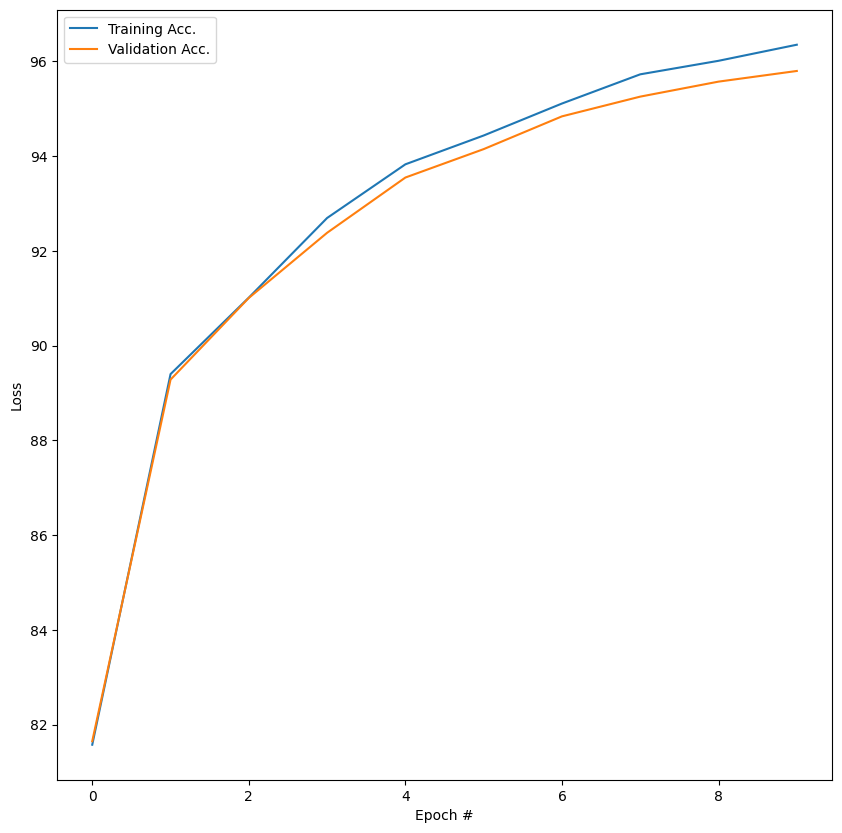

In [27]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


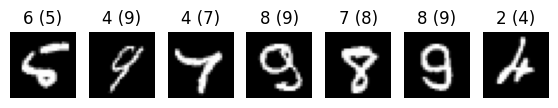

In [28]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

## Tim's solution (question 1):
Varying batch sizes:

Batch size: 8
Epoch 0: training loss: 0.20317968272603562, accuracy: 94.01666666666667
Epoch 0: val. loss: 0.21062706129695288, val. accuracy: 93.75833333333333
Epoch 1: training loss: 0.14441368525473808, accuracy: 95.53125
Epoch 1: val. loss: 0.1532480501909352, val. accuracy: 95.5
Epoch 2: training loss: 0.11603992742694148, accuracy: 96.52291666666667
Epoch 2: val. loss: 0.13645148503887078, val. accuracy: 96.0
Epoch 3: training loss: 0.10292033348502445, accuracy: 96.89791666666666
Epoch 3: val. loss: 0.12345287569606443, val. accuracy: 96.40833333333333
Epoch 4: training loss: 0.0996675538642412, accuracy: 97.00625000000001
Epoch 4: val. loss: 0.12386527959310237, val. accuracy: 96.56666666666666
Epoch 5: training loss: 0.08058123693049371, accuracy: 97.53958333333334
Epoch 5: val. loss: 0.10942852227475669, val. accuracy: 96.68333333333334
Epoch 6: training loss: 0.07365135300147692, accuracy: 97.75833333333334
Epoch 6: val. loss: 0.10387875691659186, val. accuracy: 96.833333333

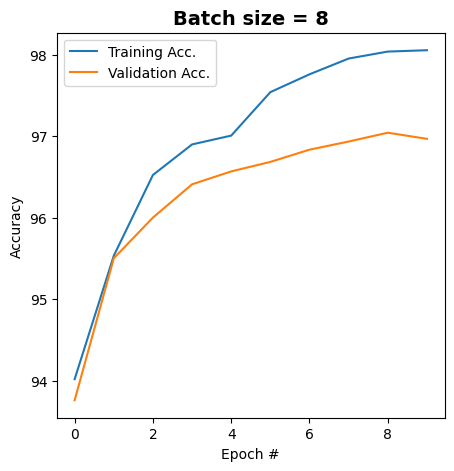

Batch size: 16
Epoch 0: training loss: 0.2079104307970653, accuracy: 93.81458333333333
Epoch 0: val. loss: 0.21801267016120254, val. accuracy: 93.44166666666666
Epoch 1: training loss: 0.15150633462677554, accuracy: 95.3625
Epoch 1: val. loss: 0.1629297904248039, val. accuracy: 95.05
Epoch 2: training loss: 0.12852346902210654, accuracy: 96.08541666666667
Epoch 2: val. loss: 0.14723206935854008, val. accuracy: 95.8
Epoch 3: training loss: 0.10985018546925858, accuracy: 96.71875
Epoch 3: val. loss: 0.13520108918488646, val. accuracy: 96.09166666666667
Epoch 4: training loss: 0.09297495297977973, accuracy: 97.26666666666667
Epoch 4: val. loss: 0.12153117978658216, val. accuracy: 96.42500000000001
Epoch 5: training loss: 0.09414412505941194, accuracy: 97.13333333333334
Epoch 5: val. loss: 0.12484443687989066, val. accuracy: 96.53333333333333
Epoch 6: training loss: 0.07967596004718022, accuracy: 97.6
Epoch 6: val. loss: 0.11526062439587743, val. accuracy: 96.59166666666667
Epoch 7: traini

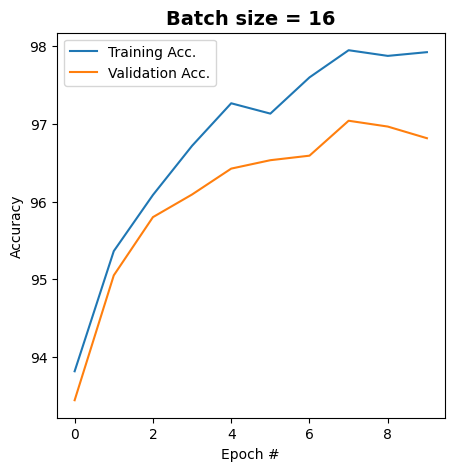

Batch size: 32
Epoch 0: training loss: 0.2727302234371503, accuracy: 91.97291666666668
Epoch 0: val. loss: 0.265690583238999, val. accuracy: 91.75
Epoch 1: training loss: 0.18075188180121282, accuracy: 94.6125
Epoch 1: val. loss: 0.1843355305418372, val. accuracy: 94.48333333333333
Epoch 2: training loss: 0.13787625179967533, accuracy: 95.92708333333333
Epoch 2: val. loss: 0.1489908685411016, val. accuracy: 95.40833333333333
Epoch 3: training loss: 0.12158312389642621, accuracy: 96.42916666666666
Epoch 3: val. loss: 0.14062526525308688, val. accuracy: 95.75833333333334
Epoch 4: training loss: 0.10727515749353915, accuracy: 96.85625
Epoch 4: val. loss: 0.13233629751950501, val. accuracy: 96.31666666666666
Epoch 5: training loss: 0.09447349592422445, accuracy: 97.26875
Epoch 5: val. loss: 0.12415813140571118, val. accuracy: 96.36666666666667
Epoch 6: training loss: 0.08290928349333505, accuracy: 97.53125
Epoch 6: val. loss: 0.11772681120224297, val. accuracy: 96.53333333333333
Epoch 7: t

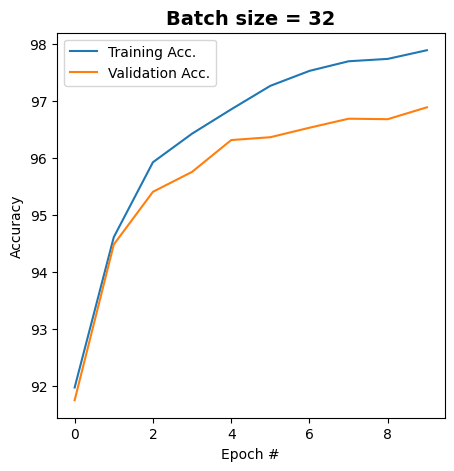

Batch size: 64
Epoch 0: training loss: 0.4240286396741867, accuracy: 88.14375
Epoch 0: val. loss: 0.4187369771460269, val. accuracy: 88.01666666666667
Epoch 1: training loss: 0.26004059267044066, accuracy: 92.49583333333334
Epoch 1: val. loss: 0.25847377832186347, val. accuracy: 92.40833333333333
Epoch 2: training loss: 0.19270893634359043, accuracy: 94.4625
Epoch 2: val. loss: 0.1987281095513955, val. accuracy: 93.98333333333333
Epoch 3: training loss: 0.16173219106346368, accuracy: 95.18541666666667
Epoch 3: val. loss: 0.17242026877926386, val. accuracy: 94.91666666666667
Epoch 4: training loss: 0.14066940943151712, accuracy: 95.89583333333334
Epoch 4: val. loss: 0.15409140223934453, val. accuracy: 95.35833333333333
Epoch 5: training loss: 0.12152042869230112, accuracy: 96.49375
Epoch 5: val. loss: 0.14266312918923002, val. accuracy: 95.65833333333333
Epoch 6: training loss: 0.11005974203596512, accuracy: 96.76875
Epoch 6: val. loss: 0.13464826771474264, val. accuracy: 95.99166666666

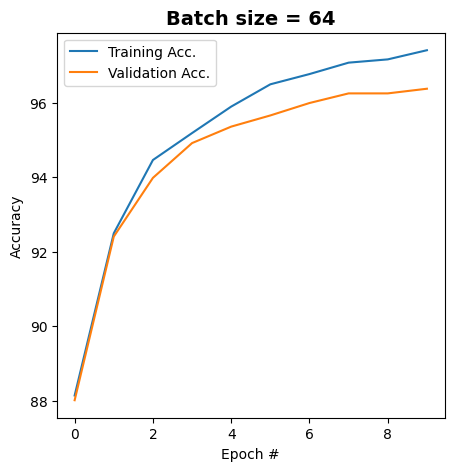

Batch size: 128
Epoch 0: training loss: 0.8146084108352661, accuracy: 76.325
Epoch 0: val. loss: 0.8100201741177985, val. accuracy: 75.83333333333333
Epoch 1: training loss: 0.39633242789904277, accuracy: 88.96666666666667
Epoch 1: val. loss: 0.3896997117615761, val. accuracy: 88.70833333333333
Epoch 2: training loss: 0.29581677897771197, accuracy: 91.63125
Epoch 2: val. loss: 0.2902449510516004, val. accuracy: 91.33333333333333
Epoch 3: training loss: 0.24483414471149445, accuracy: 92.94166666666666
Epoch 3: val. loss: 0.24336839031348836, val. accuracy: 92.75
Epoch 4: training loss: 0.20950887908538182, accuracy: 93.92291666666667
Epoch 4: val. loss: 0.2120188299487246, val. accuracy: 93.55833333333334
Epoch 5: training loss: 0.18687255370616912, accuracy: 94.60833333333333
Epoch 5: val. loss: 0.19172824213796474, val. accuracy: 94.28333333333333
Epoch 6: training loss: 0.16486580037077267, accuracy: 95.29791666666667
Epoch 6: val. loss: 0.1737471018779151, val. accuracy: 94.84166666

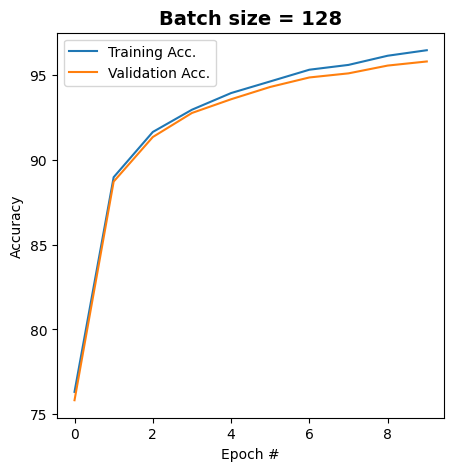

Batch size: 256
Epoch 0: training loss: 1.8156590899254412, accuracy: 46.35
Epoch 0: val. loss: 1.8111844214987247, val. accuracy: 46.50833333333333
Epoch 1: training loss: 0.6503085405268567, accuracy: 81.60208333333333
Epoch 1: val. loss: 0.6448411523027623, val. accuracy: 81.29166666666666
Epoch 2: training loss: 0.4533748407947256, accuracy: 87.1875
Epoch 2: val. loss: 0.4480650393252677, val. accuracy: 86.96666666666667
Epoch 3: training loss: 0.37117846627184686, accuracy: 89.53541666666666
Epoch 3: val. loss: 0.3654489701098584, val. accuracy: 89.10833333333333
Epoch 4: training loss: 0.31620957940182787, accuracy: 90.95625000000001
Epoch 4: val. loss: 0.31078362655132374, val. accuracy: 90.48333333333333
Epoch 5: training loss: 0.2901744990748294, accuracy: 91.65833333333333
Epoch 5: val. loss: 0.2855194562927206, val. accuracy: 91.25833333333333
Epoch 6: training loss: 0.26390364488705675, accuracy: 92.37291666666667
Epoch 6: val. loss: 0.2611169653370025, val. accuracy: 91.90

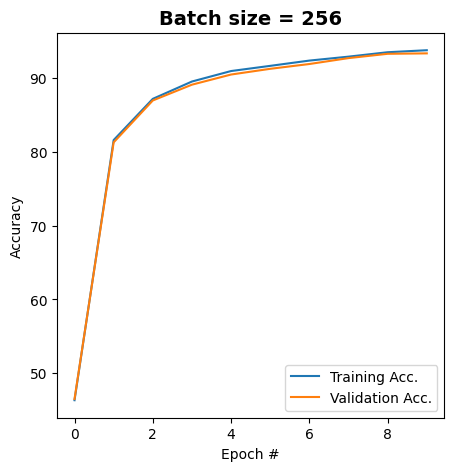

Batch size: 512
Epoch 0: training loss: 2.278703836684531, accuracy: 12.208333333333334
Epoch 0: val. loss: 2.2786662181218467, val. accuracy: 12.216666666666667
Epoch 1: training loss: 2.1605456636307085, accuracy: 31.54375
Epoch 1: val. loss: 2.159550666809082, val. accuracy: 31.75
Epoch 2: training loss: 1.2959685959714524, accuracy: 65.53958333333333
Epoch 2: val. loss: 1.2891256511211395, val. accuracy: 66.04166666666667
Epoch 3: training loss: 0.751361905260289, accuracy: 78.64791666666666
Epoch 3: val. loss: 0.7419207766652107, val. accuracy: 78.13333333333333
Epoch 4: training loss: 0.5961641897546485, accuracy: 83.08541666666667
Epoch 4: val. loss: 0.5872441480557123, val. accuracy: 82.75
Epoch 5: training loss: 0.5107304257281283, accuracy: 85.67291666666667
Epoch 5: val. loss: 0.5022504987816016, val. accuracy: 85.51666666666667
Epoch 6: training loss: 0.45194443457938255, accuracy: 87.35208333333333
Epoch 6: val. loss: 0.44349534685413045, val. accuracy: 87.34166666666667
E

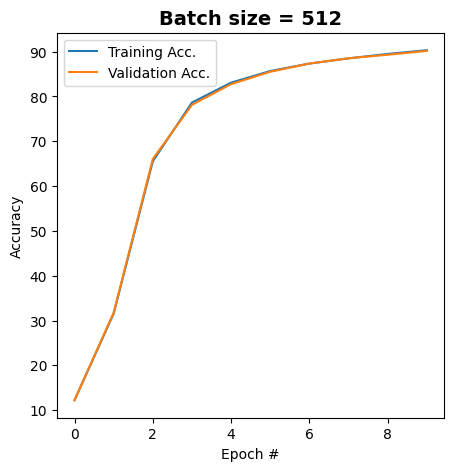

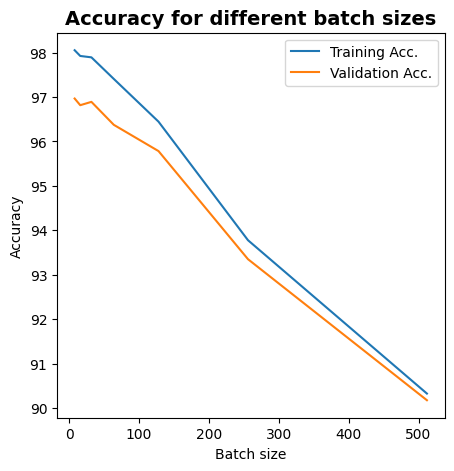

CPU times: user 20min 22s, sys: 3.27 s, total: 20min 25s
Wall time: 20min 34s


In [37]:
%%time

batch_train_acc = []
batch_val_acc = []

batch_sizes = [8, 16, 32, 64, 128, 256, 512]
for batch_size in batch_sizes:
    print('Batch size: %d' % batch_size)

    # The dataloader makes our dataset iterable
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

    epochs = 10
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Collect values for batch_sizes vs accuacy plot
    batch_train_acc.append(acc)
    batch_val_acc.append(val_acc)

    # close/delete previous plots
    plt.close('all')

    pltsize=1
    plt.figure(figsize=(5*pltsize, 5 * pltsize))
    plt.title('Batch size = %d' % batch_size, fontsize=14, fontweight='bold')
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# close/delete previous plots
plt.close('all')

pltsize=1
plt.figure(figsize=(5*pltsize, 5 * pltsize))
plt.title('Accuracy for different batch sizes', fontsize=14, fontweight='bold')
plt.plot(batch_sizes, batch_train_acc,label = 'Training Acc.' )
plt.plot(batch_sizes, batch_val_acc, label = 'Validation Acc.' )
plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Varying learning rates:

Learning rate: 0.010
Epoch 0: training loss: 0.4619454516842961, accuracy: 87.15416666666667
Epoch 0: val. loss: 0.4552753675083319, val. accuracy: 86.95833333333334
Epoch 1: training loss: 0.2886458930084482, accuracy: 91.86458333333334
Epoch 1: val. loss: 0.2817276675179601, val. accuracy: 91.675
Epoch 2: training loss: 0.21854567800803731, accuracy: 93.70833333333334
Epoch 2: val. loss: 0.21587442858641345, val. accuracy: 93.5
Epoch 3: training loss: 0.18195134631901358, accuracy: 94.72500000000001
Epoch 3: val. loss: 0.18288799717153112, val. accuracy: 94.60833333333333
Epoch 4: training loss: 0.15360116986309488, accuracy: 95.49375
Epoch 4: val. loss: 0.1599174946900457, val. accuracy: 95.30833333333332
Epoch 5: training loss: 0.1344768881589795, accuracy: 96.07916666666667
Epoch 5: val. loss: 0.14643483698088675, val. accuracy: 95.63333333333334
Epoch 6: training loss: 0.12276577480711663, accuracy: 96.43333333333334
Epoch 6: val. loss: 0.13822332261813183, val. accuracy: 95.8999

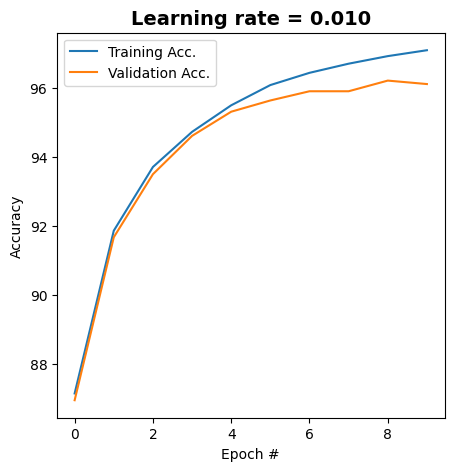

Learning rate: 0.025
Epoch 0: training loss: 0.28431680355345207, accuracy: 91.74583333333334
Epoch 0: val. loss: 0.2765569966423015, val. accuracy: 91.43333333333334
Epoch 1: training loss: 0.18135764754734313, accuracy: 94.57708333333333
Epoch 1: val. loss: 0.18207223289087415, val. accuracy: 94.30833333333334
Epoch 2: training loss: 0.13230343982841197, accuracy: 96.07916666666667
Epoch 2: val. loss: 0.14152402382033566, val. accuracy: 95.66666666666667
Epoch 3: training loss: 0.12053922512258093, accuracy: 96.34583333333333
Epoch 3: val. loss: 0.1340018542362377, val. accuracy: 95.79166666666666
Epoch 4: training loss: 0.10515567709422127, accuracy: 96.83958333333334
Epoch 4: val. loss: 0.12091030258056708, val. accuracy: 96.38333333333333
Epoch 5: training loss: 0.09658949718729128, accuracy: 97.07291666666666
Epoch 5: val. loss: 0.11659738085589683, val. accuracy: 96.39166666666667
Epoch 6: training loss: 0.09417809313658897, accuracy: 97.07708333333333
Epoch 6: val. loss: 0.1176

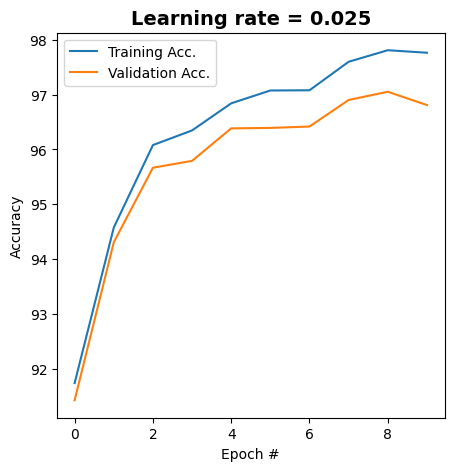

Learning rate: 0.050
Epoch 0: training loss: 0.20219384642752508, accuracy: 93.90625
Epoch 0: val. loss: 0.20063732762386402, val. accuracy: 93.73333333333333
Epoch 1: training loss: 0.14740114009481234, accuracy: 95.61041666666667
Epoch 1: val. loss: 0.1587734047261377, val. accuracy: 95.10833333333333
Epoch 2: training loss: 0.11438647219480481, accuracy: 96.51458333333333
Epoch 2: val. loss: 0.13890953336834597, val. accuracy: 95.69166666666666
Epoch 3: training loss: 0.10020181105843706, accuracy: 96.96666666666667
Epoch 3: val. loss: 0.12632081138171877, val. accuracy: 96.18333333333334
Epoch 4: training loss: 0.09246076761406342, accuracy: 97.2
Epoch 4: val. loss: 0.12383855758021431, val. accuracy: 96.31666666666666
Epoch 5: training loss: 0.0827583219203807, accuracy: 97.44375
Epoch 5: val. loss: 0.11290014455304481, val. accuracy: 96.71666666666667
Epoch 6: training loss: 0.07391105759891797, accuracy: 97.7375
Epoch 6: val. loss: 0.11347413282771594, val. accuracy: 96.76666666

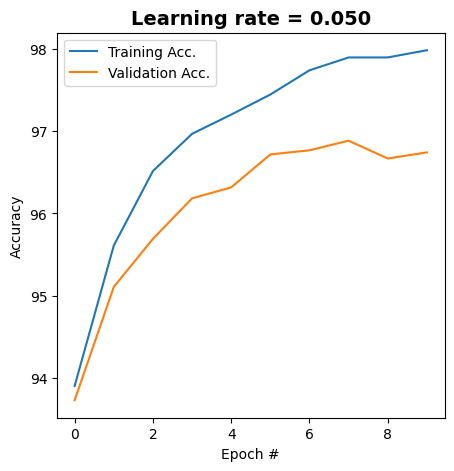

Learning rate: 0.075
Epoch 0: training loss: 0.20069209817276956, accuracy: 94.00625000000001
Epoch 0: val. loss: 0.20574338793816666, val. accuracy: 93.95833333333333
Epoch 1: training loss: 0.14006778105705356, accuracy: 95.82291666666667
Epoch 1: val. loss: 0.1481718799471855, val. accuracy: 95.575
Epoch 2: training loss: 0.12277209187040959, accuracy: 96.27291666666666
Epoch 2: val. loss: 0.13692285315847647, val. accuracy: 95.84166666666667
Epoch 3: training loss: 0.09877045597981972, accuracy: 97.03958333333334
Epoch 3: val. loss: 0.12094381701697905, val. accuracy: 96.61666666666666
Epoch 4: training loss: 0.09588153517772055, accuracy: 97.075
Epoch 4: val. loss: 0.11811725046547751, val. accuracy: 96.35000000000001
Epoch 5: training loss: 0.08205301517795306, accuracy: 97.46458333333334
Epoch 5: val. loss: 0.10948589982977137, val. accuracy: 96.75
Epoch 6: training loss: 0.07913105542619693, accuracy: 97.60208333333334
Epoch 6: val. loss: 0.11187399985998248, val. accuracy: 96.

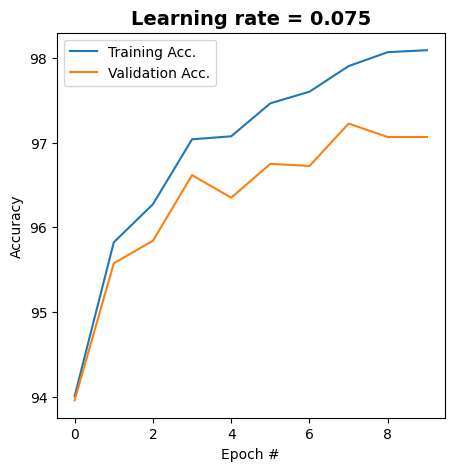

Learning rate: 0.100
Epoch 0: training loss: 0.20167308573091092, accuracy: 93.89583333333333
Epoch 0: val. loss: 0.20143087733040255, val. accuracy: 93.95
Epoch 1: training loss: 0.12790693566579528, accuracy: 96.08125
Epoch 1: val. loss: 0.14166162946866825, val. accuracy: 95.65
Epoch 2: training loss: 0.13294048842104772, accuracy: 95.79375
Epoch 2: val. loss: 0.15560868582983192, val. accuracy: 95.33333333333334
Epoch 3: training loss: 0.12879070875211618, accuracy: 96.06041666666667
Epoch 3: val. loss: 0.15547702153174517, val. accuracy: 95.29166666666666
Epoch 4: training loss: 0.09395026638695465, accuracy: 97.1625
Epoch 4: val. loss: 0.11610848174065662, val. accuracy: 96.58333333333333
Epoch 5: training loss: 0.08328755706778611, accuracy: 97.39583333333334
Epoch 5: val. loss: 0.11365287777894022, val. accuracy: 96.7
Epoch 6: training loss: 0.07538518200753606, accuracy: 97.70625
Epoch 6: val. loss: 0.113321632050133, val. accuracy: 96.65
Epoch 7: training loss: 0.075259558530

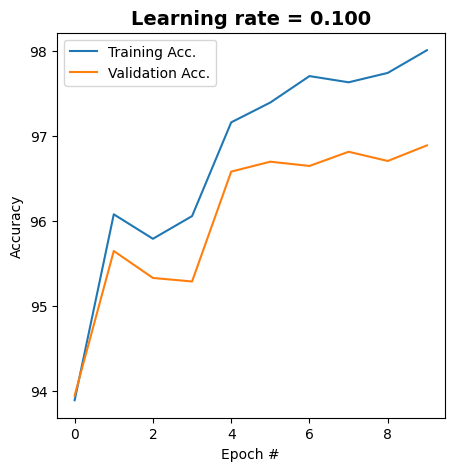

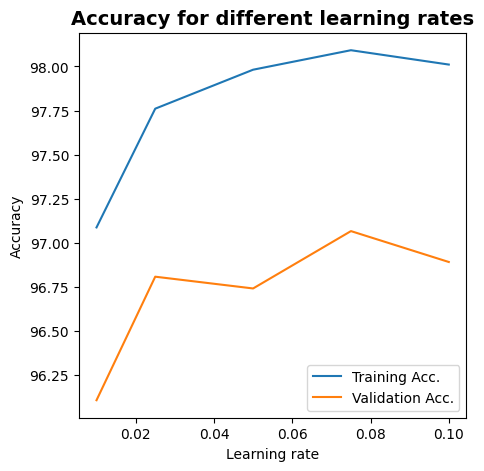

CPU times: user 16min 57s, sys: 2.75 s, total: 16min 59s
Wall time: 17min 17s


In [42]:
%%time

lr_train_acc = []
lr_val_acc = []

batch_size = 16
learn_rates = [0.01, 0.025, 0.05, 0.075, 0.1]
for learn_rate in learn_rates:
    print('Learning rate: %.3f' % learn_rate)

    # The dataloader makes our dataset iterable
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learn_rate)

    epochs = 10
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Collect values for batch_sizes vs accuacy plot
    lr_train_acc.append(acc)
    lr_val_acc.append(val_acc)

    # close/delete previous plots
    plt.close('all')

    pltsize=1
    plt.figure(figsize=(5*pltsize, 5 * pltsize))
    plt.title('Learning rate = %.3f' % learn_rate, fontsize=14, fontweight='bold')
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# close/delete previous plots
plt.close('all')

pltsize=1
plt.figure(figsize=(5*pltsize, 5 * pltsize))
plt.title('Accuracy for different learning rates', fontsize=14, fontweight='bold')
plt.plot(learn_rates, lr_train_acc,label = 'Training Acc.' )
plt.plot(learn_rates, lr_val_acc, label = 'Validation Acc.' )
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Different activation functions:

In [45]:
class NonlinearClassifierLeakyReLU(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.LeakyReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x


class NonlinearClassifierELU(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ELU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

class NonlinearClassifierHardswish(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Hardswish(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Hardswish(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Hardswish(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

Activation function: ReLU
Epoch 0: training loss: 0.20947529341404636, accuracy: 93.62083333333334
Epoch 0: val. loss: 0.2134277139622718, val. accuracy: 93.46666666666667
Epoch 1: training loss: 0.16355735609695937, accuracy: 94.99375
Epoch 1: val. loss: 0.18216227209024752, val. accuracy: 94.30833333333334
Epoch 2: training loss: 0.12051632773924696, accuracy: 96.375
Epoch 2: val. loss: 0.13783733964990824, val. accuracy: 96.16666666666667
Epoch 3: training loss: 0.10827775538646771, accuracy: 96.64583333333333
Epoch 3: val. loss: 0.13810827204709253, val. accuracy: 95.89999999999999
Epoch 4: training loss: 0.10916202439022406, accuracy: 96.72291666666666
Epoch 4: val. loss: 0.13976170599010462, val. accuracy: 96.1
Epoch 5: training loss: 0.10654427651765097, accuracy: 96.69791666666666
Epoch 5: val. loss: 0.13957895653182642, val. accuracy: 96.025
Epoch 6: training loss: 0.07690235710085835, accuracy: 97.61875
Epoch 6: val. loss: 0.11733102198558239, val. accuracy: 96.54166666666667

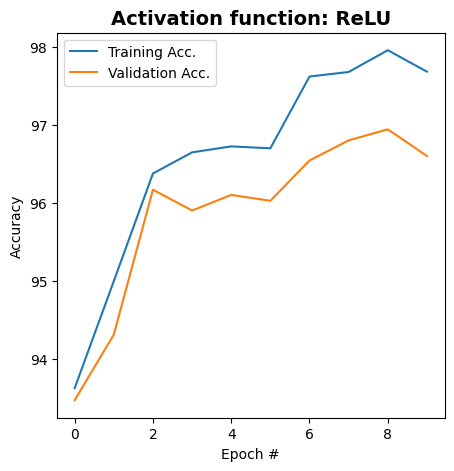

Activation function: LeakyReLU
Epoch 0: training loss: 0.19590394866086233, accuracy: 94.04375
Epoch 0: val. loss: 0.19867392345021168, val. accuracy: 93.86666666666666
Epoch 1: training loss: 0.14196316090074834, accuracy: 95.71458333333334
Epoch 1: val. loss: 0.1546952344176049, val. accuracy: 95.45
Epoch 2: training loss: 0.12052631242972954, accuracy: 96.34375
Epoch 2: val. loss: 0.13632949279551393, val. accuracy: 95.95833333333333
Epoch 3: training loss: 0.10901309361883128, accuracy: 96.6125
Epoch 3: val. loss: 0.13392988912792256, val. accuracy: 95.88333333333333
Epoch 4: training loss: 0.08964966045731368, accuracy: 97.2375
Epoch 4: val. loss: 0.1188022930463776, val. accuracy: 96.61666666666666
Epoch 5: training loss: 0.08445606008621204, accuracy: 97.43958333333333
Epoch 5: val. loss: 0.1162927798179832, val. accuracy: 96.55833333333334
Epoch 6: training loss: 0.07917026876461265, accuracy: 97.60416666666667
Epoch 6: val. loss: 0.10998756958982751, val. accuracy: 96.90833333

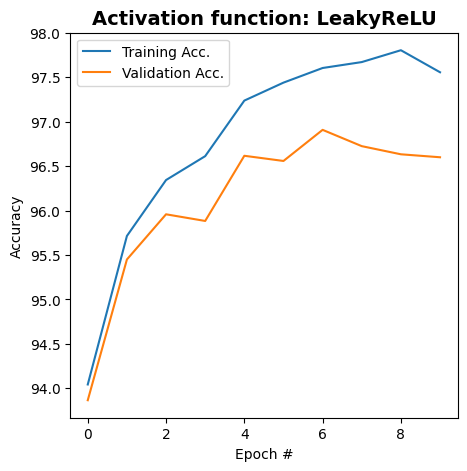

Activation function: ELU
Epoch 0: training loss: 0.2130740312449634, accuracy: 93.5875
Epoch 0: val. loss: 0.21497412918011347, val. accuracy: 93.38333333333333
Epoch 1: training loss: 0.1383591983441729, accuracy: 95.73125
Epoch 1: val. loss: 0.14382035935328652, val. accuracy: 95.46666666666667
Epoch 2: training loss: 0.11790575854829513, accuracy: 96.32916666666667
Epoch 2: val. loss: 0.13431845080169538, val. accuracy: 95.95833333333333
Epoch 3: training loss: 0.0954395464778257, accuracy: 97.02916666666667
Epoch 3: val. loss: 0.10824426997802221, val. accuracy: 96.69166666666666
Epoch 4: training loss: 0.09737083659577184, accuracy: 96.97708333333334
Epoch 4: val. loss: 0.11971875553127999, val. accuracy: 96.39166666666667
Epoch 5: training loss: 0.07939163863629801, accuracy: 97.54791666666667
Epoch 5: val. loss: 0.10717747565021273, val. accuracy: 96.70833333333333
Epoch 6: training loss: 0.07103794540686552, accuracy: 97.81458333333333
Epoch 6: val. loss: 0.10167881895751149, v

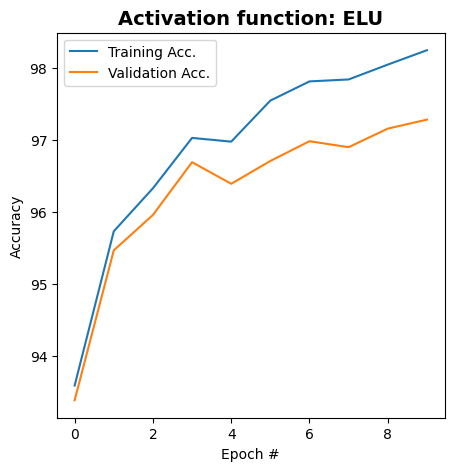

Activation function: Hardswish
Epoch 0: training loss: 0.2123840058237159, accuracy: 93.63541666666667
Epoch 0: val. loss: 0.2106486181865136, val. accuracy: 93.45833333333333
Epoch 1: training loss: 0.13923371390488076, accuracy: 95.76666666666667
Epoch 1: val. loss: 0.15083151514083146, val. accuracy: 95.38333333333333
Epoch 2: training loss: 0.1021255923458569, accuracy: 96.83958333333334
Epoch 2: val. loss: 0.12244688279259329, val. accuracy: 96.23333333333333
Epoch 3: training loss: 0.08858597195960465, accuracy: 97.3125
Epoch 3: val. loss: 0.11320727732913413, val. accuracy: 96.51666666666667
Epoch 4: training loss: 0.07783038470934843, accuracy: 97.58333333333333
Epoch 4: val. loss: 0.1104836831773088, val. accuracy: 96.78333333333333
Epoch 5: training loss: 0.06908349011669634, accuracy: 97.79791666666667
Epoch 5: val. loss: 0.100506719484382, val. accuracy: 96.91666666666666
Epoch 6: training loss: 0.07296625111546504, accuracy: 97.65
Epoch 6: val. loss: 0.11302945306949551, v

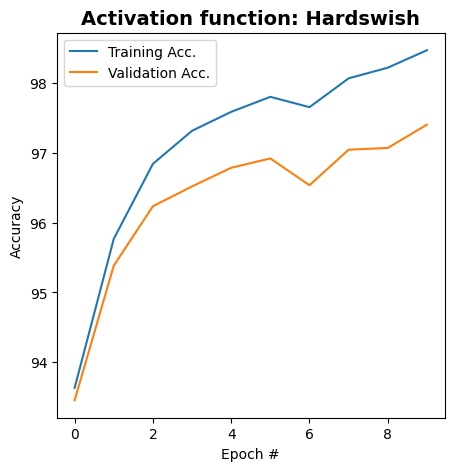

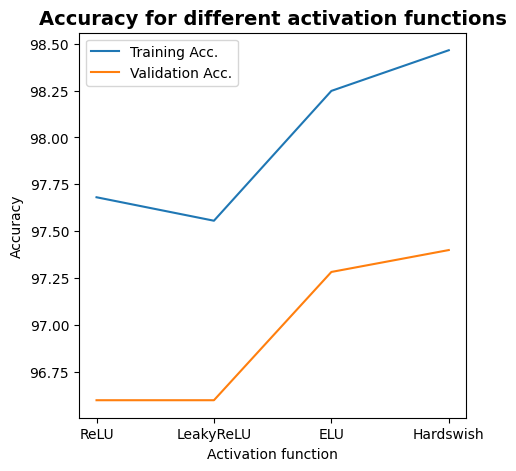

CPU times: user 13min 19s, sys: 2.05 s, total: 13min 21s
Wall time: 13min 26s


In [50]:
%%time

afun_train_acc = []
afun_val_acc = []

batch_size = 16
learn_rate = 0.075
act_func_names = ["ReLU", "LeakyReLU", "ELU", "Hardswish"]
models = [NonlinearClassifier, NonlinearClassifierLeakyReLU, NonlinearClassifierELU, NonlinearClassifierHardswish]
for i in range(len(models)):
    print('Activation function: %s' % act_func_names[i])

    # The dataloader makes our dataset iterable
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    nonlinear_model = models[i]()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learn_rate)

    epochs = 10
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

    # Collect values for batch_sizes vs accuacy plot
    afun_train_acc.append(acc)
    afun_val_acc.append(val_acc)

    # close/delete previous plots
    plt.close('all')

    pltsize=1
    plt.figure(figsize=(5*pltsize, 5 * pltsize))
    plt.title('Activation function: %s' % act_func_names[i], fontsize=14, fontweight='bold')
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# close/delete previous plots
plt.close('all')

pltsize=1
plt.figure(figsize=(5*pltsize, 5 * pltsize))
plt.title('Accuracy for different activation functions', fontsize=14, fontweight='bold')
plt.plot(range(len(models)), afun_train_acc,label = 'Training Acc.' )
plt.plot(range(len(models)), afun_val_acc, label = 'Validation Acc.' )
plt.xticks(range(len(models)), act_func_names)
plt.xlabel('Activation function')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


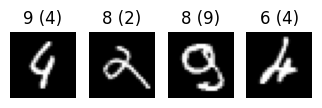

In [51]:
show_failures(nonlinear_model, test_dataloader)

## Tim's solution (question 2):

Bonus: What is a learning rate scheduler?

A learning rate scheduler is a mechanism that adjusts the learning rate as training progress.  This can enable, for example, faster learning during initial epocs followed by slower learning while converging onto a solution.